In [1]:
import torch
import pickle
import config
import os
import numpy as np
import evaluation as E
import matplotlib.pyplot as plt
import FigureConfig as FC

In [2]:
metric = 'maa'
# metric = 'acc'

In [3]:
cf = 0.05

In [4]:
# Device
device = config.device
# device = torch.device('cuda:0')
# device = 'cpu'

# Prepare data
## Datasets
datasets = os.listdir('./Datasets/datasets/')
datasets = [d for d in datasets if d.endswith('.p')]
datasets.sort()

## Load data
names   = []
num_in  = []
num_out = []
X_trains = []
y_trains = []
X_valids = []
y_valids = []
X_tests = []
y_tests = []

for dataset in datasets:
    datapath = os.path.join('./Datasets/datasets/' + dataset)
    with open(datapath, 'rb') as f:
        data = pickle.load(f)
        
    X_test     = data['X_test']
    y_test     = data['y_test']
    data_name  = data['name']

    N_class    = data['n_class']
    N_feature  = data['n_feature']
    N_test     = X_test.shape[0]
    
    print('Loading', data_name, N_feature, N_class, N_test)
    
    names.append(data_name)
    num_in.append(N_feature)
    num_out.append(N_class)
    
    X_tests.append(X_test.to(device))
    y_tests.append(y_test.to(device))

N_tasks = len(X_tests)
X_tests = config.DataReshape(X_tests, config.MAX_IN)
print('Finish data loading.')

Loading acuteinflammation 6 2 25
Loading acutenephritis 6 2 25
Loading balancescale 4 3 126
Loading blood 4 2 150
Loading breastcancer 9 2 58
Loading breastcancerwisc 9 2 140
Loading breasttissue 9 6 22
Loading ecoli 7 8 68
Loading energyy1 8 3 154
Loading energyy2 8 3 154
Loading fertility 9 2 21
Loading glass 9 6 43
Loading habermansurvival 3 2 62
Loading hayesroth 3 3 32
Loading ilpdindianliver 9 2 117
Loading iris 4 3 31
Loading mammographic 5 2 193
Loading monks1 6 2 111
Loading monks2 6 2 120
Loading monks3 6 2 110
Loading pima 8 2 154
Loading pittsburgbridgesMATERIAL 7 3 22
Loading pittsburgbridgesRELL 7 3 21
Loading pittsburgbridgesSPAN 7 3 18
Loading pittsburgbridgesTORD 7 2 20
Loading pittsburgbridgesTYPE 7 6 22
Loading postoperative 8 3 19
Loading seeds 7 3 43
Loading teaching 5 3 31
Loading tictactoe 9 2 192
Loading vertebralcolumn2clases 6 2 63
Loading vertebralcolumn3clases 6 3 63
Finish data loading.


In [5]:
alphas = np.zeros([102])
alphas[1:-1] = np.logspace(np.log(1e-5), np.log(1e5), 100, base=np.e)
alphas[-1] = 1e6
alphas = np.round(alphas, 5)
alphas_str = [str(alpha) for alpha in alphas]
alphas

array([0.00000000e+00, 1.00000000e-05, 1.00000000e-05, 2.00000000e-05,
       2.00000000e-05, 3.00000000e-05, 3.00000000e-05, 4.00000000e-05,
       5.00000000e-05, 6.00000000e-05, 8.00000000e-05, 1.00000000e-04,
       1.30000000e-04, 1.60000000e-04, 2.10000000e-04, 2.60000000e-04,
       3.30000000e-04, 4.10000000e-04, 5.20000000e-04, 6.60000000e-04,
       8.30000000e-04, 1.05000000e-03, 1.32000000e-03, 1.67000000e-03,
       2.10000000e-03, 2.66000000e-03, 3.35000000e-03, 4.23000000e-03,
       5.34000000e-03, 6.73000000e-03, 8.50000000e-03, 1.07200000e-02,
       1.35300000e-02, 1.70700000e-02, 2.15400000e-02, 2.71900000e-02,
       3.43000000e-02, 4.32900000e-02, 5.46200000e-02, 6.89300000e-02,
       8.69700000e-02, 1.09750000e-01, 1.38490000e-01, 1.74750000e-01,
       2.20510000e-01, 2.78260000e-01, 3.51120000e-01, 4.43060000e-01,
       5.59080000e-01, 7.05480000e-01, 8.90220000e-01, 1.12332000e+00,
       1.41747000e+00, 1.78865000e+00, 2.25702000e+00, 2.84804000e+00,
      

In [6]:
Results = torch.zeros([len(alphas), 30, 2, N_tasks])

In [7]:
for a in range(len(alphas_str)):
    alpha = alphas_str[a]
    for seed in range(1,31):
        spnn = torch.load(f'./result/super pNN full {config.full_topology_str}/model/spnn_{alpha}_{seed}')
        with torch.no_grad():
            prediction = spnn(X_tests)
            if metric == 'acc':
                Results[a, seed-1, 0, :] = torch.tensor(E.AccList(prediction, y_tests)).view(1,-1)
            elif metric == 'maa':
                Results[a, seed-1, 0, :] = torch.tensor(E.MAAList(prediction, y_tests)).view(1,-1)
            Results[a, seed-1, 1, :] = spnn.GetNorm(config.pnorm)

In [8]:
alphas[0] = 1e-6
alphas[-1] = 1e6

In [9]:
Results.shape

torch.Size([102, 30, 2, 32])

In [10]:
result = Results.clone()

In [11]:
from scipy import signal

for t in range(N_tasks):
    for seed in range(30):
        sss = result[:,seed,0,t].numpy()
        
        b, a = signal.butter(2, cf, 'lowpass') 
        low = signal.filtfilt(b, a, sss) 

        b, a = signal.butter(2, cf, 'highpass')  
        high = signal.filtfilt(b, a, sss) 

        result[:,seed,0,t] = torch.tensor(low+high*0.2)
result.shape

torch.Size([102, 30, 2, 32])

In [12]:
Results_zero = torch.mean(Results[0,:,0,:], dim=0)
Results_infty = torch.mean(Results[-1,:,0,:], dim=0)
np.savetxt(f'./result/super pNN full {config.full_topology_str}/test_{metric}_zero.txt',  Results_zero.numpy(),  fmt='%.5f')
np.savetxt(f'./result/super pNN full {config.full_topology_str}/test_{metric}_infty.txt', Results_infty.numpy(), fmt='%.5f')

In [13]:
result = torch.cat([result[:,:,:,:22],result[:,:,:,23:]], dim=3)
result.shape

torch.Size([102, 30, 2, 31])

In [14]:
result_filter = torch.mean(result[:,:,0,:], dim=1)
result_filter.shape

torch.Size([102, 31])

In [15]:
result_filter[:,:] = result_filter[:,:] / result_filter[0,:]

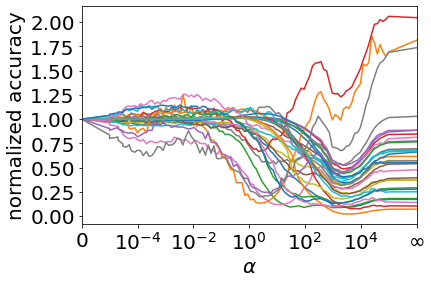

In [16]:
# log10 scale for x-axis
plt.xscale('log') 

for t in range(N_tasks-1):
    plt.plot(np.array(alphas), result_filter[:,t].numpy())

# draw label and ticks
# plt.title(f'{ds}', fontsize=25)
plt.xlabel(r'$\alpha$', fontsize=20);
plt.ylabel(r'normalized accuracy', fontsize=20);

plt.xticks(fontsize=20)
plt.xticks([1e-6, 1e-4, 1e-2, 1, 1e2, 1e4, 1e6], [r'$0$', r'$10^{-4}$', r'$10^{-2}$', r'$10^{0}$', r'$10^{2}$', r'$10^{4}$', r'$\infty$'])
plt.yticks(fontsize=20)

# limite ranges
plt.xlim([1e-6, 1e6])
# plt.ylim([max([0, 0.9*min([min(mean_acc_PNN-std_acc_PNN), min(mean_acc_AAPNN-std_acc_AAPNN)])]),
#           min([1.02, 1.05*max([max(mean_acc_PNN+std_acc_PNN), max(mean_acc_AAPNN+std_acc_AAPNN)])])]);
# plt.legend();

# save figure
plt.savefig(f'../figures/seperate_{metric}_{config.full_topology_str}.pdf', format='pdf', bbox_inches='tight')

In [17]:
ALPHAvsACC_alltask_mean = torch.mean(result_filter, dim=1)

In [18]:
re_temp = torch.mean(result[:,:,0,:], dim=2)
re_temp = re_temp / torch.mean(re_temp, dim=1, keepdim=True)
re_temp.shape

torch.Size([102, 30])

In [19]:
ALPHAvsACC_alltask_std = torch.std(re_temp, dim=1)

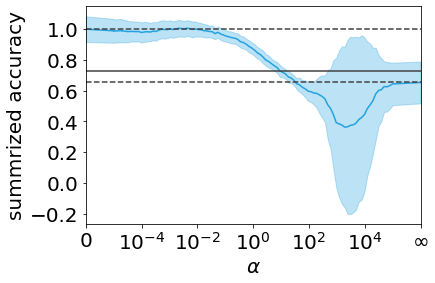

In [20]:
# log10 scale for x-axis
plt.xscale('log') 


# draw std
plt.fill_between(np.array(alphas), ALPHAvsACC_alltask_mean-ALPHAvsACC_alltask_std, ALPHAvsACC_alltask_mean+ALPHAvsACC_alltask_std, alpha=0.3, color=FC.Cyan);

# draw mean
plt.plot(np.array(alphas), ALPHAvsACC_alltask_mean.numpy(), color=FC.Cyan)

# draw extreme
plt.plot(np.array(alphas), ALPHAvsACC_alltask_mean.numpy()*0+1, '--', color=FC.Black)
plt.plot(np.array(alphas), ALPHAvsACC_alltask_mean.numpy()*0+ALPHAvsACC_alltask_mean.numpy()[-1], '--', color=FC.Black)
# draw baseline
plt.plot(np.array(alphas), ALPHAvsACC_alltask_mean.numpy()*0+0.726, '-', color=FC.Black)

# draw label and ticks
# plt.title(f'{ds}', fontsize=25)
plt.xlabel(r'$\alpha$', fontsize=20);
plt.ylabel(r'summrized accuracy', fontsize=20);

plt.xticks(fontsize=20)
plt.xticks([1e-6, 1e-4, 1e-2, 1, 1e2, 1e4, 1e6], [r'$0$', r'$10^{-4}$', r'$10^{-2}$', r'$10^{0}$', r'$10^{2}$', r'$10^{4}$', r'$\infty$'])
plt.yticks(fontsize=20)

# limite ranges
plt.xlim([1e-6, 1e6])
# plt.ylim([max([0, 0.9*min([min(mean_acc_PNN-std_acc_PNN), min(mean_acc_AAPNN-std_acc_AAPNN)])]),
#           min([1.02, 1.05*max([max(mean_acc_PNN+std_acc_PNN), max(mean_acc_AAPNN+std_acc_AAPNN)])])]);
# plt.legend();

# save figure
plt.savefig(f'../figures/{metric}_{config.full_topology_str}.pdf', format='pdf', bbox_inches='tight')

In [21]:
NORMvsACC = torch.mean(result, dim=3)
NORMvsACC.shape

torch.Size([102, 30, 2])

In [22]:
NORMvsACC[:,:,0] = NORMvsACC[:,:,0] / NORMvsACC[0,:,0]

In [23]:
NORMvsACC1 = NORMvsACC[:,:,0].view(1,-1)
NORMvsACC2 = NORMvsACC[:,:,1].view(1,-1)
NORMvsACC = torch.cat([NORMvsACC1, NORMvsACC2], dim=0)
NORMvsACC.shape

torch.Size([2, 3060])

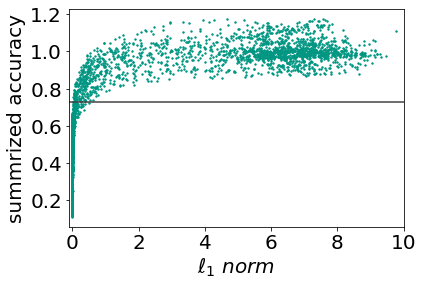

In [24]:
plt.xlabel(r'$norm$')
plt.ylabel(r'accuracy')



# draw mean
plt.scatter(NORMvsACC[1,:]*73, NORMvsACC[0,:], color=FC.Green, s=2)

# draw label and ticks
# plt.title(f'{ds}', fontsize=25)
plt.xlabel(r'$\ell_1\  norm$', fontsize=20);
plt.ylabel(r'summrized accuracy', fontsize=20);

# a = np.linspace(-0.1,10,1000)
# plt.plot(a, -100/(a+0.2)+1, '-', color=FC.Black)
# draw baseline
plt.plot(np.linspace(-1,100,1000), np.linspace(-1,1,1000)*0+0.726, '-', color=FC.Black)

plt.xticks(fontsize=20)
# plt.xticks([0, 0.03, 0.06, 0.09, 0.12, 0.15], ['0','0.03','0.06','0.09','0.12','0.15'])
plt.yticks(fontsize=20)

# limite ranges
plt.xlim([-0.1, 10])
# plt.ylim([max([0, 0.9*min([min(mean_acc_PNN-std_acc_PNN), min(mean_acc_AAPNN-std_acc_AAPNN)])]),
#           min([1.02, 1.05*max([max(mean_acc_PNN+std_acc_PNN), max(mean_acc_AAPNN+std_acc_AAPNN)])])]);
# plt.legend();

# save figure
plt.savefig(f'../figures/norm_{metric}_{config.full_topology_str}.pdf', format='pdf', bbox_inches='tight')